# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Imports**

In [ ]:
# Standard Library
import math
import os
import re
from collections import Counter, defaultdict

# Third-party Libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import umap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
nltk.download('punkt_tab')

# Sentence Transformers
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **CV Scoring Using VSM**

In [ ]:
# Step 1: Define cleaning function
def clean_cv_text(text):
    text = re.sub(r'-{5,}.*?-{5,}', ' ', text)            # remove page lines
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)            # remove non-ASCII
    text = re.sub(r'\s+', ' ', text)                      # normalize whitespace
    return text.strip()

# Step 2: Paths
raw_folder = "/content/drive/MyDrive/IR CVs DATASET"             # 🔁 change this to your raw CVs folder path
cleaned_folder = "/content/drive/MyDrive/IR CVs DATASET/CleanedCVs"    # cleaned CVs will be saved here
os.makedirs(cleaned_folder, exist_ok=True)

In [ ]:
# Step 3: Read, clean and save cleaned CVs
cv_filenames = []
for filename in os.listdir(raw_folder):
    if filename.endswith(".txt"):
        raw_text = ""  # Initialize raw_text
        try:
            # Try reading with utf-8 first
            with open(os.path.join(raw_folder, filename), "r", encoding="utf-8") as f:
                raw_text = f.read()
        except UnicodeDecodeError:
            # If utf-8 fails, try reading with latin-1
            print(f"Warning: UTF-8 decode failed for {filename}. Trying latin-1.")
            with open(os.path.join(raw_folder, filename), "r", encoding="latin-1") as f:
                raw_text = f.read()
        except Exception as e:
            # Catch any other potential errors during file reading
            print(f"Error reading file {filename}: {e}")
            continue # Skip this file and move to the next one

        cleaned_text = clean_cv_text(raw_text)

        # Save cleaned version
        cleaned_path = os.path.join(cleaned_folder, filename)
        # Always save as utf-8 after cleaning to ensure consistency
        with open(cleaned_path, "w", encoding="utf-8") as f:
            f.write(cleaned_text)

        cv_filenames.append(filename)

print(f"✅ Cleaned {len(cv_filenames)} CVs and saved to '{cleaned_folder}'")

✅ Cleaned 25 CVs and saved to '/content/drive/MyDrive/IR CVs DATASET/CleanedCVs'


In [ ]:
# Step 4: Load cleaned CVs and generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # light & accurate

cleaned_cvs = []
for filename in cv_filenames:
    with open(os.path.join(cleaned_folder, filename), "r", encoding="utf-8") as f:
        cleaned_cvs.append(f.read())

embeddings = model.encode(cleaned_cvs)

# Step 5: Save embeddings
os.makedirs("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output", exist_ok=True)
np.save("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output/cv_embeddings.npy", embeddings)

# Save as CSV (optional but readable)
df = pd.DataFrame(embeddings)
df['filename'] = cv_filenames
df.to_csv("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output/cv_embedding.csv", index=False)

print("✅Embeddings generated and saved to 'embeddings_output/'")

✅Embeddings generated and saved to 'embeddings_output/'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


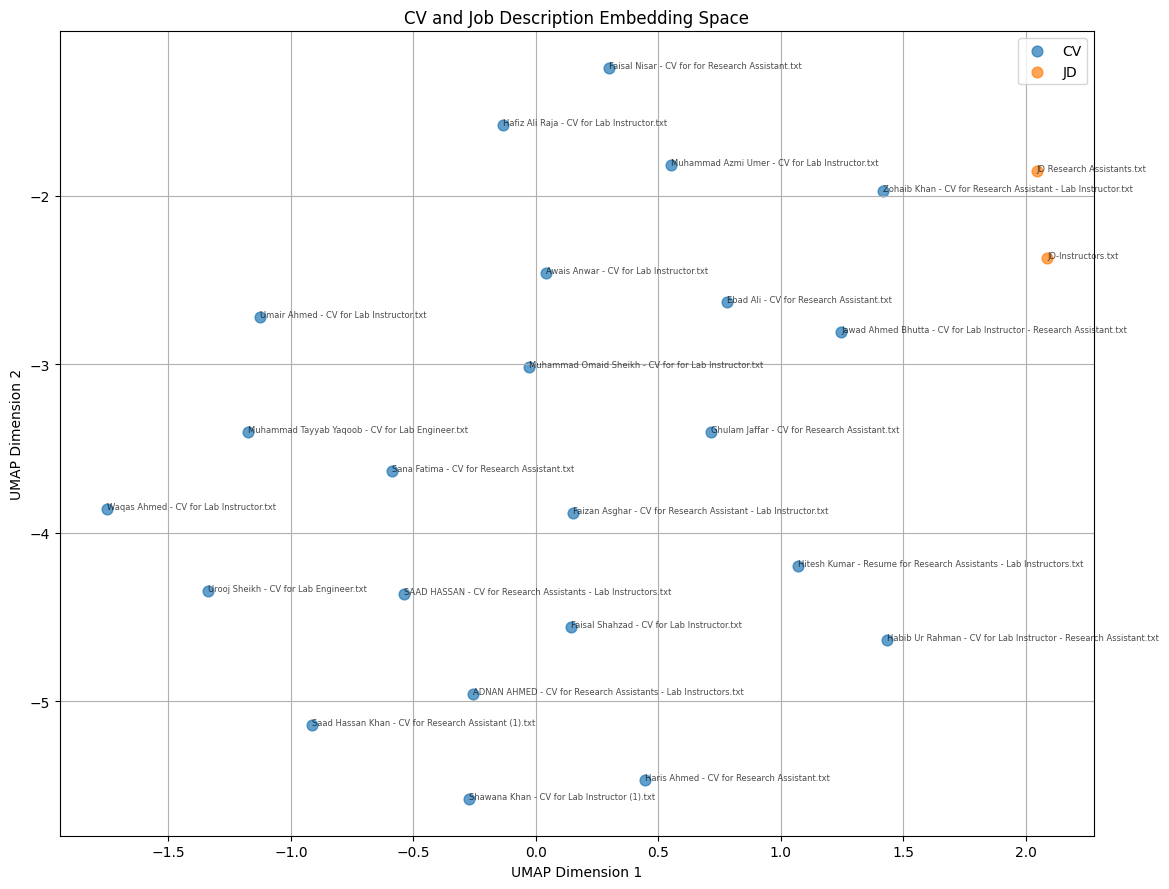

In [ ]:
# 🔁 Paths
cleaned_folder = "/content/drive/MyDrive/IR CVs DATASET/CleanedCVs"
jd_files = ["JD Research Assistants.txt", "JD-Instructors.txt"]

# 🔹 Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 🔹 Load all CVs
file_texts = []
file_labels = []
file_names = []  # 🔺 Store filenames for labeling

for filename in os.listdir(cleaned_folder):
    filepath = os.path.join(cleaned_folder, filename)
    if filename.endswith(".txt"):
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()
            file_texts.append(text)
            file_names.append(filename)  # 🔺 Save the filename
            if filename in jd_files:
                file_labels.append("JD")
            else:
                file_labels.append("CV")

# 🔹 Generate embeddings
embeddings = model.encode(file_texts)

# 🔹 Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# 🔹 Plot
plt.figure(figsize=(12, 9))

for label in set(file_labels):
    idxs = [i for i, lbl in enumerate(file_labels) if lbl == label]
    plt.scatter(
        embeddings_2d[idxs, 0],
        embeddings_2d[idxs, 1],
        label=label,
        s=60,
        alpha=0.7
    )

# 🔺 Annotate each point with filename
for i, name in enumerate(file_names):
    plt.text(
        embeddings_2d[i, 0],
        embeddings_2d[i, 1],
        name,  # 🔺 Show filename
        fontsize=6,
        alpha=0.7
    )

plt.title("CV and Job Description Embedding Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


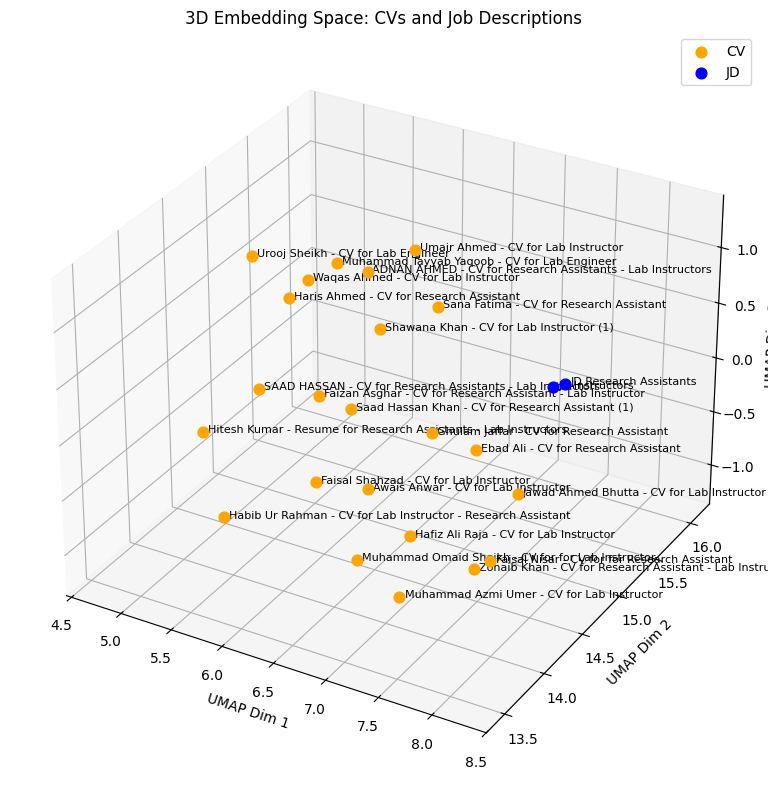

In [ ]:
# Step 1: Reduce embeddings to 3D
reducer_3d = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=3, metric='cosine', random_state=42)
embeddings_3d = reducer_3d.fit_transform(embeddings)

# Step 2: Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot with different colors for JD and CV
for i, (x, y, z) in enumerate(embeddings_3d):
    label = file_labels[i]
    color = 'blue' if label == 'JD' else 'orange'
    ax.scatter(x, y, z, c=color, label=label if i == file_labels.index(label) else "", s=60)
    ax.text(x + 0.05, y, z, os.path.splitext(os.listdir(cleaned_folder)[i])[0], fontsize=8)

# Step 4: Final settings
ax.set_title("3D Embedding Space: CVs and Job Descriptions")
ax.set_xlabel("UMAP Dim 1")
ax.set_ylabel("UMAP Dim 2")
ax.set_zlabel("UMAP Dim 3")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Convert embeddings to numpy array if not already
embeddings = np.array(embeddings)

# Store results
similarity_results = {}

# Loop over each JD
for jd_file in jd_files:
    try:
        jd_index = file_labels.index("JD") if jd_file == jd_files[0] else file_labels.index("JD", file_labels.index("JD")+1)
        jd_embedding = embeddings[jd_index].reshape(1, -1)

        cv_similarities = []

        for i, label in enumerate(file_labels):
            if label == "CV":
                sim = cosine_similarity(jd_embedding, embeddings[i].reshape(1, -1))[0][0]
                cv_similarities.append((os.listdir(cleaned_folder)[i], sim))

        # Sort by highest similarity
        sorted_sims = sorted(cv_similarities, key=lambda x: x[1], reverse=True)
        similarity_results[jd_file] = sorted_sims

    except Exception as e:
        print(f"Error processing JD '{jd_file}': {e}")

In [ ]:
for jd_file, sims in similarity_results.items():
    print(f"\n🔹 Similarity to: {jd_file}")
    for i, (cv_name, sim_score) in enumerate(sims[:], 1):  # Top 10
        print(f"{i}. {cv_name} — {sim_score:.4f}")


🔹 Similarity to: JD Research Assistants.txt
1. Zohaib Khan - CV for Research Assistant - Lab Instructor.txt — 0.3425
2. Jawad Ahmed Bhutta - CV for Lab Instructor - Research Assistant.txt — 0.3241
3. Muhammad Azmi Umer - CV for Lab Instructor.txt — 0.3019
4. Muhammad Omaid Sheikh - CV for for Lab Instructor.txt — 0.2747
5. Awais Anwar - CV for Lab Instructor.txt — 0.2698
6. Faizan Asghar - CV for Research Assistant - Lab Instructor.txt — 0.2588
7. Ghulam Jaffar - CV for Research Assistant.txt — 0.2385
8. Ebad Ali - CV for Research Assistant.txt — 0.2285
9. Hitesh Kumar - Resume for Research Assistants - Lab Instructors.txt — 0.2275
10. Waqas Ahmed - CV for Lab Instructor.txt — 0.2054
11. Faisal Shahzad - CV for Lab Instructor.txt — 0.1993
12. Umair Ahmed - CV for Lab Instructor.txt — 0.1947
13. SAAD HASSAN - CV for Research Assistants - Lab Instructors.txt — 0.1907
14. Haris Ahmed - CV for Research Assistant.txt — 0.1896
15. Sana Fatima - CV for Research Assistant.txt — 0.1884
16. Hab

# **CV Scoring Using Language Model**

In [ ]:
def build_bigram_model(text):
    tokens = ['<s>'] + tokenize(text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))

    unigram_counts = Counter(tokens)
    bigram_counts = Counter(bigrams)

    vocab = set(tokens)
    V = len(vocab)

    def prob(w1, w2):
        return (bigram_counts[(w1, w2)] + 1) / (unigram_counts[w1] + V)

    return prob

In [ ]:
def score_text_likelihood(text, model):
    tokens = ['<s>'] + tokenize(text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))
    log_prob = 0
    for w1, w2 in bigrams:
        log_prob += math.log(model(w1, w2))
    return log_prob

In [ ]:
jd_models = {}
tokenize = nltk.word_tokenize

for jd_file in jd_files:
    with open(os.path.join(cleaned_folder, jd_file), "r", encoding="utf-8") as f:
        jd_text = f.read()
    jd_models[jd_file] = build_bigram_model(jd_text)

In [ ]:
cv_scores_by_jd = {}

for jd_name, jd_model in jd_models.items():
    scores = []
    for filename in os.listdir(cleaned_folder):
        if filename.endswith(".txt") and filename not in jd_files:
            with open(os.path.join(cleaned_folder, filename), "r", encoding="utf-8") as f:
                cv_text = f.read()
            score = score_text_likelihood(cv_text, jd_model)
            scores.append((filename, score))

    # Sort by highest likelihood
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)
    cv_scores_by_jd[jd_name] = ranked

In [ ]:
for jd_name, ranked_scores in cv_scores_by_jd.items():
    print(f"\n🔹 JD as Language Model: {jd_name}")
    for rank, (cv_file, score) in enumerate(ranked_scores[:], 1):
        print(f"{rank}. {cv_file} — LogLikelihood: {score:.2f}")


🔹 JD as Language Model: JD Research Assistants.txt
1. Faizan Asghar - CV for Research Assistant - Lab Instructor.txt — LogLikelihood: -885.06
2. Muhammad Azmi Umer - CV for Lab Instructor.txt — LogLikelihood: -1353.09
3. Waqas Ahmed - CV for Lab Instructor.txt — LogLikelihood: -1495.21
4. Ebad Ali - CV for Research Assistant.txt — LogLikelihood: -1538.55
5. Hitesh Kumar - Resume for Research Assistants - Lab Instructors.txt — LogLikelihood: -1689.88
6. Awais Anwar - CV for Lab Instructor.txt — LogLikelihood: -1757.28
7. SAAD HASSAN - CV for Research Assistants - Lab Instructors.txt — LogLikelihood: -2036.25
8. Faisal Nisar - CV for for Research Assistant.txt — LogLikelihood: -2040.32
9. Hafiz Ali Raja - CV for Lab Instructor.txt — LogLikelihood: -2040.32
10. Sana Fatima - CV for Research Assistant.txt — LogLikelihood: -2172.42
11. ADNAN AHMED - CV for Research Assistants - Lab Instructors.txt — LogLikelihood: -2193.81
12. Jawad Ahmed Bhutta - CV for Lab Instructor - Research Assistant

# **CV Recommender**

In [ ]:
# Step 1: Combine and Normalize Scores (VSM + Bi-gram)
final_combined_ranking = {}

for jd_name in cv_scores_by_jd.keys():
    print(f"\n🔹 Final Ranking for JD: {jd_name}")

    # Get scores
    bigram_dict = dict(cv_scores_by_jd[jd_name])  # {filename: log-likelihood}
    vsm_dict = dict(similarity_results[jd_name])  # {filename: cosine similarity}

    # Common CVs in both
    common_cvs = set(bigram_dict.keys()) & set(vsm_dict.keys())

    # Extract raw values
    bigram_values = [bigram_dict[cv] for cv in common_cvs]

    # Min-max normalization for log-likelihoods (then invert because less negative = better)
    min_ll = min(bigram_values)
    max_ll = max(bigram_values)

    def normalize_log_likelihood(ll):
        return ((ll - min_ll) / (max_ll - min_ll))

    combined_list = []
    for cv in common_cvs:
        vsm_score = vsm_dict[cv]                  # Already 0–1
        norm_ll = normalize_log_likelihood(bigram_dict[cv])
        alpha = 0.7
        combined_score = alpha * vsm_score + (1 - alpha) * norm_ll
        combined_list.append((cv, vsm_score, bigram_dict[cv], norm_ll, combined_score))

    # Sort by final combined score
    ranked = sorted(combined_list, key=lambda x: x[4], reverse=True)
    final_combined_ranking[jd_name] = ranked

    # Print Results
    print(f"{'Rank':<4} {'CV Filename':<60} {'VSM':>8} {'LogLikelihood':>15} {'Norm LL':>12} {'Combined':>10}")
    print("-" * 115)
    for i, (cv, vsm, ll, norm_ll, combined) in enumerate(ranked, 1):
        print(f"{i:<4} {cv:<60} {vsm:>8.4f} {ll:>15.2f} {norm_ll:>12.4f} {combined:>10.4f}")



🔹 Final Ranking for JD: JD Research Assistants.txt
Rank CV Filename                                                       VSM   LogLikelihood      Norm LL   Combined
-------------------------------------------------------------------------------------------------------------------
1    Muhammad Azmi Umer - CV for Lab Instructor.txt                 0.3019        -1353.09       0.9016     0.4818
2    Faizan Asghar - CV for Research Assistant - Lab Instructor.txt   0.2588         -885.06       1.0000     0.4812
3    Jawad Ahmed Bhutta - CV for Lab Instructor - Research Assistant.txt   0.3241        -2259.92       0.7111     0.4402
4    Awais Anwar - CV for Lab Instructor.txt                        0.2698        -1757.28       0.8167     0.4339
5    Ebad Ali - CV for Research Assistant.txt                       0.2285        -1538.55       0.8627     0.4187
6    Hitesh Kumar - Resume for Research Assistants - Lab Instructors.txt   0.2275        -1689.88       0.8309     0.4085
7    Waqas 

# **JD Scoring Using VSM**

In [ ]:
# Step 1: Define cleaning function
def clean_cv_text(text):
    text = re.sub(r'-{5,}.*?-{5,}', ' ', text)            # remove page lines
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)            # remove non-ASCII
    text = re.sub(r'\s+', ' ', text)                      # normalize whitespace
    return text.strip()

# Step 2: Paths
raw_folder = "/content/drive/MyDrive/IR CVs DATASET"             # 🔁 change this to your raw CVs folder path
cleaned_folder = "/content/drive/MyDrive/IR CVs DATASET/CleanedCVs"    # cleaned CVs will be saved here
os.makedirs(cleaned_folder, exist_ok=True)

In [ ]:
# Step 3: Read, clean and save cleaned CVs
cv_filenames = []
for filename in os.listdir(raw_folder):
    if filename.endswith(".txt"):
        raw_text = ""  # Initialize raw_text
        try:
            # Try reading with utf-8 first
            with open(os.path.join(raw_folder, filename), "r", encoding="utf-8") as f:
                raw_text = f.read()
        except UnicodeDecodeError:
            # If utf-8 fails, try reading with latin-1
            print(f"Warning: UTF-8 decode failed for {filename}. Trying latin-1.")
            with open(os.path.join(raw_folder, filename), "r", encoding="latin-1") as f:
                raw_text = f.read()
        except Exception as e:
            # Catch any other potential errors during file reading
            print(f"Error reading file {filename}: {e}")
            continue # Skip this file and move to the next one

        cleaned_text = clean_cv_text(raw_text)

        # Save cleaned version
        cleaned_path = os.path.join(cleaned_folder, filename)
        # Always save as utf-8 after cleaning to ensure consistency
        with open(cleaned_path, "w", encoding="utf-8") as f:
            f.write(cleaned_text)

        cv_filenames.append(filename)

print(f"✅ Cleaned {len(cv_filenames)} CVs and saved to '{cleaned_folder}'")

✅ Cleaned 25 CVs and saved to '/content/drive/MyDrive/IR CVs DATASET/CleanedCVs'


In [ ]:
# Step 4: Load cleaned CVs and generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # light & accurate

cleaned_cvs = []
for filename in cv_filenames:
    with open(os.path.join(cleaned_folder, filename), "r", encoding="utf-8") as f:
        cleaned_cvs.append(f.read())

embeddings = model.encode(cleaned_cvs)

# Step 5: Save embeddings
os.makedirs("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output", exist_ok=True)
np.save("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output/cv_embeddings.npy", embeddings)

# Save as CSV (optional but readable)
df = pd.DataFrame(embeddings)
df['filename'] = cv_filenames
df.to_csv("/content/drive/MyDrive/IR CVs DATASET/Embeddings_output/cv_embedding.csv", index=False)

print("✅Embeddings generated and saved to 'embeddings_output/'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅Embeddings generated and saved to 'embeddings_output/'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


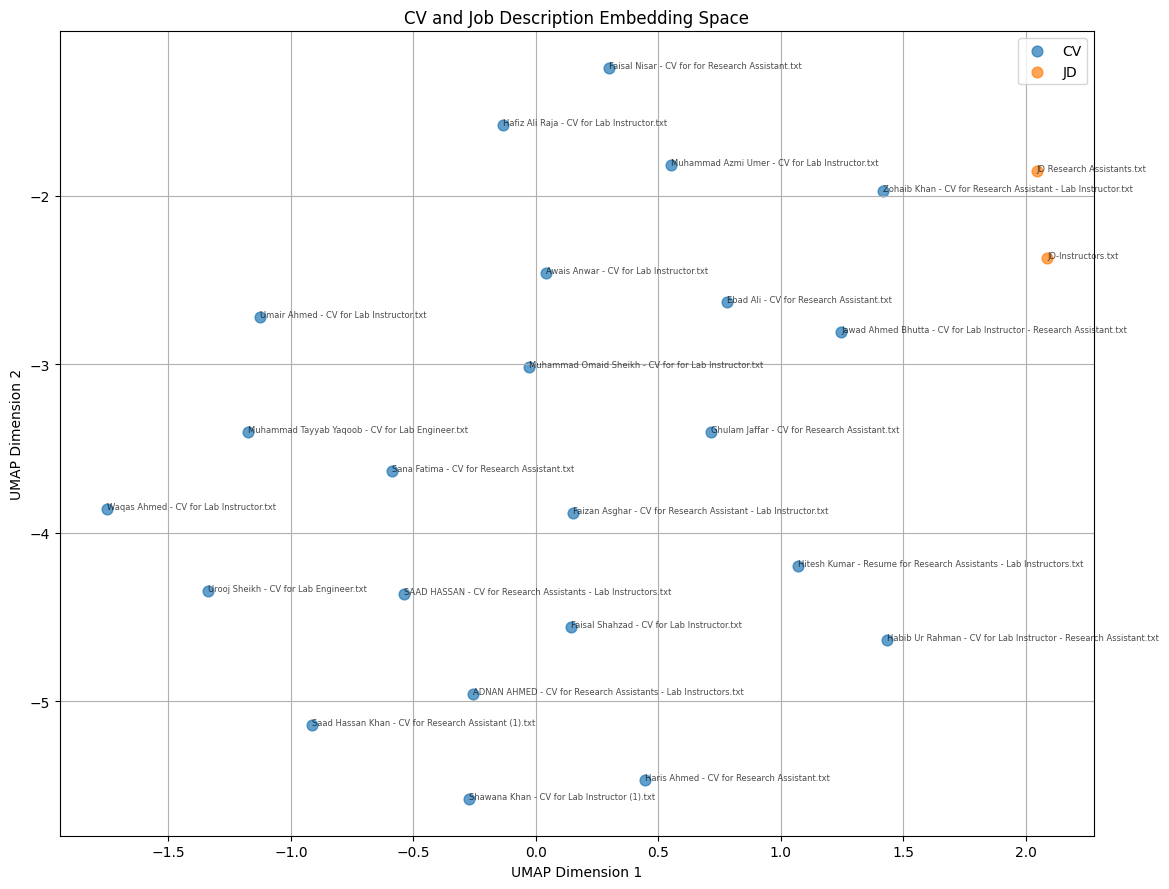

In [ ]:
# 🔁 Paths
cleaned_folder = "/content/drive/MyDrive/IR CVs DATASET/CleanedCVs"
jd_files = ["JD Research Assistants.txt", "JD-Instructors.txt"]

# 🔹 Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 🔹 Load all CVs and JDs
file_texts = []
file_labels = []
file_names = []  # 🔺 Store filenames for labeling

for filename in os.listdir(cleaned_folder):
    filepath = os.path.join(cleaned_folder, filename)
    if filename.endswith(".txt"):
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()
            file_texts.append(text)
            file_names.append(filename)  # 🔺 Save the filename
            if filename in jd_files:
                file_labels.append("JD")
            else:
                file_labels.append("CV")

# 🔹 Generate embeddings
embeddings = model.encode(file_texts)

# 🔹 Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='cosine', random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# 🔹 Plot
plt.figure(figsize=(12, 9))

for label in set(file_labels):
    idxs = [i for i, lbl in enumerate(file_labels) if lbl == label]
    plt.scatter(
        embeddings_2d[idxs, 0],
        embeddings_2d[idxs, 1],
        label=label,
        s=60,
        alpha=0.7
    )

# 🔺 Annotate each point with filename
for i, name in enumerate(file_names):
    plt.text(
        embeddings_2d[i, 0],
        embeddings_2d[i, 1],
        name,  # 🔺 Show filename
        fontsize=6,
        alpha=0.7
    )

plt.title("CV and Job Description Embedding Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


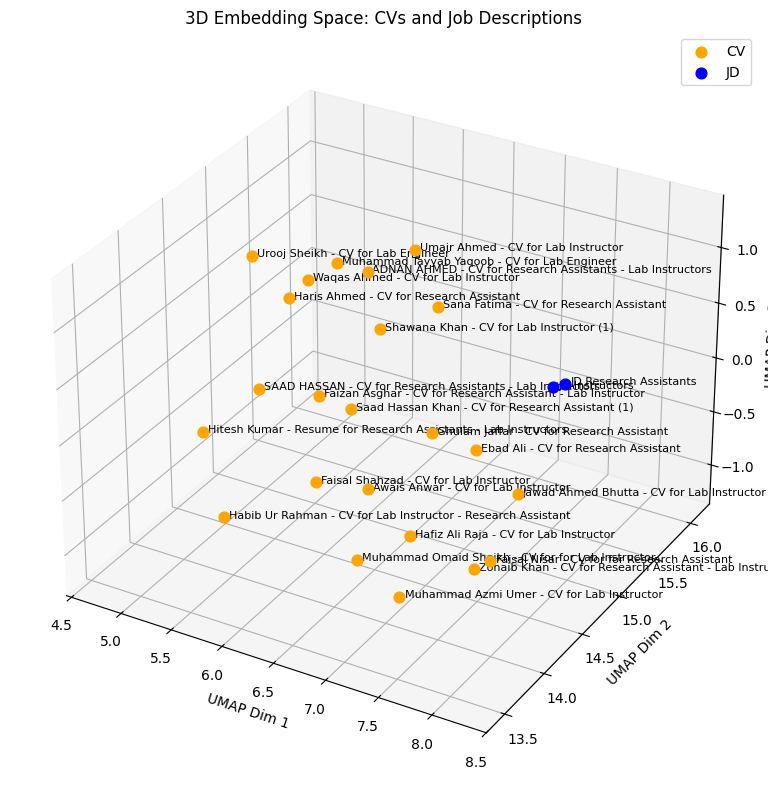

In [ ]:
# Step 1: Reduce embeddings to 3D
reducer_3d = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=3, metric='cosine', random_state=42)
embeddings_3d = reducer_3d.fit_transform(embeddings)

# Step 2: Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot with different colors for JD and CV
for i, (x, y, z) in enumerate(embeddings_3d):
    label = file_labels[i]
    color = 'blue' if label == 'JD' else 'orange'
    ax.scatter(x, y, z, c=color, label=label if i == file_labels.index(label) else "", s=60)
    ax.text(x + 0.05, y, z, os.path.splitext(file_names[i])[0], fontsize=8)

# Step 4: Final settings
ax.set_title("3D Embedding Space: CVs and Job Descriptions")
ax.set_xlabel("UMAP Dim 1")
ax.set_ylabel("UMAP Dim 2")
ax.set_zlabel("UMAP Dim 3")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Convert embeddings to numpy array if not already
embeddings = np.array(embeddings)

# Store results
similarity_results = {}

# Get list of CV files (exclude JD files)
cv_files = [name for i, name in enumerate(file_names) if file_labels[i] == "CV"]

# Loop over each CV
for cv_file in cv_files:
    try:
        cv_index = file_names.index(cv_file)
        cv_embedding = embeddings[cv_index].reshape(1, -1)

        jd_similarities = []

        for i, label in enumerate(file_labels):
            if label == "JD":
                sim = cosine_similarity(cv_embedding, embeddings[i].reshape(1, -1))[0][0]
                jd_similarities.append((file_names[i], sim))

        # Sort by highest similarity
        sorted_sims = sorted(jd_similarities, key=lambda x: x[1], reverse=True)
        similarity_results[cv_file] = sorted_sims

    except Exception as e:
        print(f"Error processing CV '{cv_file}': {e}")

for cv_file, sims in similarity_results.items():
    print(f"\n🔹 Similarity to: {cv_file}")
    for i, (jd_name, sim_score) in enumerate(sims[:], 1):  # Top JDs
        print(f"{i}. {jd_name} — {sim_score:.4f}")


🔹 Similarity to: ADNAN AHMED - CV for Research Assistants - Lab Instructors.txt
1. JD-Instructors.txt — 0.2977
2. JD Research Assistants.txt — 0.1680

🔹 Similarity to: Awais Anwar - CV for Lab Instructor.txt
1. JD-Instructors.txt — 0.4602
2. JD Research Assistants.txt — 0.2698

🔹 Similarity to: Ebad Ali - CV for Research Assistant.txt
1. JD-Instructors.txt — 0.3672
2. JD Research Assistants.txt — 0.2285

🔹 Similarity to: Faisal Nisar - CV for for Research Assistant.txt
1. JD-Instructors.txt — 0.3076
2. JD Research Assistants.txt — 0.1494

🔹 Similarity to: Faisal Shahzad - CV for Lab Instructor.txt
1. JD-Instructors.txt — 0.3205
2. JD Research Assistants.txt — 0.1993

🔹 Similarity to: Faizan Asghar - CV for Research Assistant - Lab Instructor.txt
1. JD-Instructors.txt — 0.4525
2. JD Research Assistants.txt — 0.2588

🔹 Similarity to: Ghulam Jaffar - CV for Research Assistant.txt
1. JD-Instructors.txt — 0.4873
2. JD Research Assistants.txt — 0.2385

🔹 Similarity to: Habib Ur Rahman - CV 

# **JD Scoring Using Language Model**


In [ ]:
def build_bigram_model(text):
    tokens = ['<s>'] + tokenize(text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))

    unigram_counts = Counter(tokens)
    bigram_counts = Counter(bigrams)

    vocab = set(tokens)
    V = len(vocab)

    def prob(w1, w2):
        return (bigram_counts[(w1, w2)] + 1) / (unigram_counts[w1] + V)

    return prob

In [ ]:
def score_text_likelihood(text, model):
    tokens = ['<s>'] + tokenize(text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))
    log_prob = 0
    for w1, w2 in bigrams:
        log_prob += math.log(model(w1, w2))
    return log_prob

In [ ]:
cv_models = {}
tokenize = nltk.word_tokenize

for cv_file in cv_files:
    with open(os.path.join(cleaned_folder, cv_file), "r", encoding="utf-8") as f:
        cv_text = f.read()
    cv_models[cv_file] = build_bigram_model(cv_text)

In [ ]:
jd_scores_by_cv = {}

for cv_name, cv_model in cv_models.items():
    scores = []
    for filename in file_names:
        if filename in jd_files:
            with open(os.path.join(cleaned_folder, filename), "r", encoding="utf-8") as f:
                jd_text = f.read()
            score = score_text_likelihood(jd_text, cv_model)
            scores.append((filename, score))

    # Sort by highest likelihood
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)
    jd_scores_by_cv[cv_name] = ranked

In [ ]:
for cv_name, ranked_scores in jd_scores_by_cv.items():
    print(f"\n🔹 CV as Language Model: {cv_name}")
    for rank, (jd_file, score) in enumerate(ranked_scores[:], 1):
        print(f"{rank}. {jd_file} — LogLikelihood: {score:.2f}")


🔹 CV as Language Model: ADNAN AHMED - CV for Research Assistants - Lab Instructors.txt
1. JD Research Assistants.txt — LogLikelihood: -1872.38
2. JD-Instructors.txt — LogLikelihood: -2657.76

🔹 CV as Language Model: Awais Anwar - CV for Lab Instructor.txt
1. JD Research Assistants.txt — LogLikelihood: -1850.95
2. JD-Instructors.txt — LogLikelihood: -2615.06

🔹 CV as Language Model: Ebad Ali - CV for Research Assistant.txt
1. JD Research Assistants.txt — LogLikelihood: -1781.90
2. JD-Instructors.txt — LogLikelihood: -2523.37

🔹 CV as Language Model: Faisal Nisar - CV for for Research Assistant.txt
1. JD Research Assistants.txt — LogLikelihood: -1863.45
2. JD-Instructors.txt — LogLikelihood: -2629.46

🔹 CV as Language Model: Faisal Shahzad - CV for Lab Instructor.txt
1. JD Research Assistants.txt — LogLikelihood: -1919.29
2. JD-Instructors.txt — LogLikelihood: -2713.58

🔹 CV as Language Model: Faizan Asghar - CV for Research Assistant - Lab Instructor.txt
1. JD Research Assistants.txt —

# **JD Recommender**


In [ ]:
# Step 1: Normalize all bigram scores globally across all CVs for each JD
# First, collect all bigram scores for each JD across all CVs
jd_bigram_scores = {}
for jd_file in jd_files:
    jd_bigram_scores[jd_file] = []

# Collect scores for each JD
for cv_name, cv_scores in jd_scores_by_cv.items():
    for jd_file, score in cv_scores:
        jd_bigram_scores[jd_file].append(score)

# Calculate min-max normalization parameters for each JD
jd_normalization_params = {}
for jd_file, scores in jd_bigram_scores.items():
    min_score = min(scores)
    max_score = max(scores)
    jd_normalization_params[jd_file] = (min_score, max_score)

# Normalization function for each JD
def normalize_bigram_score(score, jd_file):
    min_score, max_score = jd_normalization_params[jd_file]
    if max_score == min_score:
        return 0.5  # If all scores are the same
    return (score - min_score) / (max_score - min_score)

# Step 2: Combine and Normalize Scores (VSM + Bi-gram)
final_combined_ranking = {}

for cv_name in jd_scores_by_cv.keys():
    print(f"\n🔹 Final Ranking for CV: {cv_name}")

    # Get scores
    bigram_dict = dict(jd_scores_by_cv[cv_name])  # {filename: log-likelihood}
    vsm_dict = dict(similarity_results[cv_name])  # {filename: cosine similarity}

    # Common JDs in both
    common_jds = set(bigram_dict.keys()) & set(vsm_dict.keys())

    combined_list = []
    for jd in common_jds:
        vsm_score = vsm_dict[jd]                  # Already 0–1
        norm_ll = normalize_bigram_score(bigram_dict[jd], jd)  # Normalize with respect to JD
        alpha = 0.7
        combined_score = alpha * vsm_score + (1 - alpha) * norm_ll
        combined_list.append((jd, vsm_score, bigram_dict[jd], norm_ll, combined_score))

    # Sort by final combined score
    ranked = sorted(combined_list, key=lambda x: x[4], reverse=True)
    final_combined_ranking[cv_name] = ranked

    # Print Results
    print(f"{'Rank':<4} {'JD Filename':<60} {'VSM':>8} {'LogLikelihood':>15} {'Norm LL':>12} {'Combined':>10}")
    print("-" * 115)
    for i, (jd, vsm, ll, norm_ll, combined) in enumerate(ranked, 1):
        print(f"{i:<4} {jd:<60} {vsm:>8.4f} {ll:>15.2f} {norm_ll:>12.4f} {combined:>10.4f}")


🔹 Final Ranking for CV: ADNAN AHMED - CV for Research Assistants - Lab Instructors.txt
Rank JD Filename                                                       VSM   LogLikelihood      Norm LL   Combined
-------------------------------------------------------------------------------------------------------------------
1    JD-Instructors.txt                                             0.2977        -2657.76       0.5118     0.3619
2    JD Research Assistants.txt                                     0.1680        -1872.38       0.5281     0.2760

🔹 Final Ranking for CV: Awais Anwar - CV for Lab Instructor.txt
Rank JD Filename                                                       VSM   LogLikelihood      Norm LL   Combined
-------------------------------------------------------------------------------------------------------------------
1    JD-Instructors.txt                                             0.4602        -2615.06       0.5797     0.4960
2    JD Research Assistants.txt         

# CV AS MODEL AND JD AS A QUERY

In [ ]:

nltk.download('punkt')
tokenize = nltk.word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:


nltk.download('punkt')
# Download the missing punkt_tab resource
nltk.download('punkt_tab')

tokenize = nltk.word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def build_bigram_model(text):
    tokens = ['<s>'] + tokenize(text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))

    unigram_counts = Counter(tokens)
    bigram_counts = Counter(bigrams)

    # Laplace smoothing
    vocab = set(tokens)
    V = len(vocab)

    def prob(w1, w2):
        return (bigram_counts[(w1, w2)] + 1) / (unigram_counts[w1] + V)

    return prob

In [ ]:
def score_query_likelihood(jd_text, cv_model):
    tokens = ['<s>'] + tokenize(jd_text.lower()) + ['</s>']
    bigrams = list(nltk.bigrams(tokens))
    log_prob = 0
    for w1, w2 in bigrams:
        log_prob += math.log(cv_model(w1, w2))
    return log_prob  # Return log likelihood

In [ ]:
cv_models = {}
cv_filenames = []
for filename in os.listdir(cleaned_folder):
    if filename.endswith(".txt") and filename not in jd_files:
        path = os.path.join(cleaned_folder, filename)
        with open(path, "r", encoding="utf-8") as f:
            text = f.read()
        cv_models[filename] = build_bigram_model(text)
        cv_filenames.append(filename)

# Loop through each JD and rank CVs
for jd_file in jd_files:
    with open(os.path.join(cleaned_folder, jd_file), "r", encoding="utf-8") as f:
        jd_text = f.read()

    scores = []
    for cv_file, model in cv_models.items():
        score = score_query_likelihood(jd_text, model)
        scores.append((cv_file, score))

    # Sort CVs by likelihood of generating the JD
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    print(f"\n🔹 Ranking CVs for JD: {jd_file}")
    for rank, (cv, score) in enumerate(sorted_scores[:], 1):
        print(f"{rank}. {cv} — LogLikelihood: {score:.2f}")


🔹 Ranking CVs for JD: JD Research Assistants.txt
1. Faizan Asghar - CV for Research Assistant - Lab Instructor.txt — LogLikelihood: -1663.80
2. Muhammad Azmi Umer - CV for Lab Instructor.txt — LogLikelihood: -1740.40
3. Ebad Ali - CV for Research Assistant.txt — LogLikelihood: -1781.90
4. Waqas Ahmed - CV for Lab Instructor.txt — LogLikelihood: -1793.26
5. Hitesh Kumar - Resume for Research Assistants - Lab Instructors.txt — LogLikelihood: -1841.81
6. Awais Anwar - CV for Lab Instructor.txt — LogLikelihood: -1850.95
7. Hafiz Ali Raja - CV for Lab Instructor.txt — LogLikelihood: -1863.45
8. Faisal Nisar - CV for for Research Assistant.txt — LogLikelihood: -1863.45
9. Sana Fatima - CV for Research Assistant.txt — LogLikelihood: -1867.01
10. ADNAN AHMED - CV for Research Assistants - Lab Instructors.txt — LogLikelihood: -1872.38
11. SAAD HASSAN - CV for Research Assistants - Lab Instructors.txt — LogLikelihood: -1878.17
12. Habib Ur Rahman - CV for Lab Instructor - Research Assistant.txt